# Emulator Graduation Project 2018

## High level synthesis [HLS] based design simulation results

### Notes
+ This notebook contains the HLS simulation results for $5$ of our test cases
+ We are simulating for large number of equations $2, 100, 1000, 4000$ in order to check that the **macro-architecture** explored by the HLS tool is working as expected
+ Note that a typical RTL simulation for our core does consume lots of time; running the simulation using C is faster for verifing every thing is working as expected
+ We check the functionality of our generated HLS code by running a CO-simulatio on Vivado HLS free tool, thus ensuring the results obtained match the software expected results. Though we do this by running our algorithm for **SMALL** number of iterations

### Simulation steps
+ We generate the required C memory files via a script
+ Once generated the python script invokes the C make files to run the generated C code
  + Note the generated C code has a pre-made template for our HLS implementation\
+ Once the C simulation is done load the expected roots value from their files and a comparison is made between the two optained values
+ We compare the results by taking $\log_{10}(\left|x_{expected}-x_{obtained}\right|)$; such that the lower the difference values the better our results as compared to the software

### Some helper functions for the simulation purpose

In [20]:
import sys
import os
import pandas as pd
import pylab

pylab.rcParams["figure.figsize"] = [10, 10]

sys.path.append('../../scripts/preprocessing_script')
sys.path.append('../../scripts/preprocessing_script/parser')
from cpp_tb_generator import TestBench
import numpy as np
import pylab
from parser_class import Parser

#pylab.rcParams['figure.figsize'] = (5,5)
pylab.rcParams.update({'font.size': 15})

def compare(cpp_results_dir, actual_results_dir):
    """
    A comparison file shall be used across all the test cases
    ## Args
    + cpp_results_dir : the directory for the c++ generated file
    + actual_results_dir : the directory for the actual results text file
    """
    cpp = np.loadtxt(cpp_results_dir)
    actual = np.loadtxt(actual_results_dir)
    _p = np.log10(np.abs(cpp-actual))
    pylab.plot(_p, '-+')
    pylab.xlabel("Root index")
    pylab.ylabel("$\log_{10}$ difference")
    pylab.show()
    
def generateTestBench(num_unknwn, num_exp, iter_mem=None, nonlin='exp',num_pe=2, init_guess=0, 
                      gen_dir="../../scripts/preprocessing_script/layers_test_weights.h", 
                      max_mem_size=25000, eqn_file='eqns.txt'):
    """
    Wrapper for the generator class, attempts to generate, run the testbench
    
    ## Args
    + num_unknwn : number of unknowns
    + num_exp : nonlinear synthesized units
    + num_pe : the synthesized number of processing elements
    + iter_mem : the iteration configuration list
    + nonlin : the nonlinear function name as given in the equations.txt file
    + gen_dir: the directory for generating the .h file. Note this file
    is needed by the MAKEFILE and currently it is assumed to be at the same directory
    of the makefile; in case changed make sure to pass the correct argument
    """
    if iter_mem is None:
        iter_mem = [1000, 1900, 1]
    prsr = Parser(num_unknwn, in_file=eqn_file)
    prsr.add_nonlin_neuron(nonlin, num_exp)
    cpp_lut_mux = {nonlin :1}
    tb = TestBench(num_pe=num_pe, num_unknown=num_unknwn, init_guess=init_guess, eqn_parser=prsr,
              lut_mux_config=cpp_lut_mux, iter_mem=iter_mem, max_size = max_mem_size, )
    tb.gen_cpp(verbose=1, out_file=gen_dir)
    
def sim(res_file):
    print("\n>>>Executing automatic simulation commands\n")
    cmds = ['bash', "cd ../../scripts/preprocessing_script", 'make']
    print(os.popen(cmds[0]+';'+cmds[1]+';'+cmds[2]).read())
    print(">>>Reading the CPP generated files and plotting the difference\n")
    compare('../../scripts/preprocessing_script/results.txt', res_file)

#### TESTCASE - 1
+ Number of unknowns : 2


Calculating the module configurations
Calculating the lut indices
Calculating the wide memory weight matrix
File :  ../../scripts/preprocessing_script/layers_test_weights.h  Generated successfuly

>>>Executing automatic simulation commands

g++ tb_template.cpp
./a.out
The obtained error: 5.42101e-20
rm *.out

>>>Reading the CPP generated files and plotting the difference



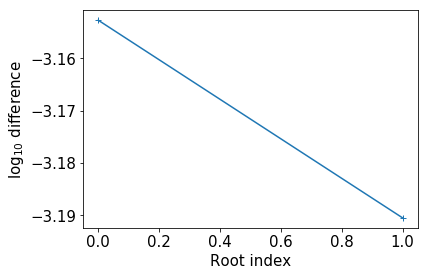

In [3]:
eqns_file = 'results/case1_eqns.txt'
roots_file = 'results/case1_roots.txt'
generateTestBench(num_exp=1, num_unknwn=2, eqn_file=eqns_file, iter_mem=[500, 5000, 1], num_pe=20)
sim(roots_file)

#### TESTCASE - 2
+ Number of unknowns : 185

Calculating the module configurations
Calculating the lut indices
Calculating the wide memory weight matrix
File :  ../../scripts/preprocessing_script/layers_test_weights.h  Generated successfuly

>>>Executing automatic simulation commands

g++ tb_template.cpp
./a.out
The obtained error: 2.50485e-07
rm *.out

>>>Reading the CPP generated files and plotting the difference



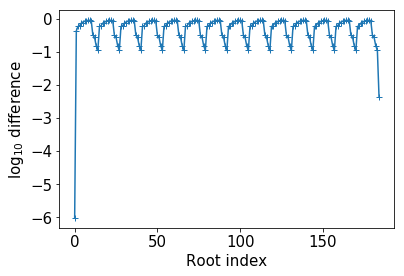

In [4]:
eqns_file = 'results/case2_eqns.txt'
roots_file = 'results/case2_roots.txt'
generateTestBench(num_exp=182, num_unknwn=185, eqn_file=eqns_file, iter_mem=[500, 15000, 1], max_mem_size=200000, num_pe=123)
sim(roots_file)

#### TESTCASE - 1
+ Number of unknowns : 1104


>>>Executing automatic simulation commands

g++ tb_template.cpp
./a.out
The obtained error: 1.84171e-06
rm *.out

>>>Reading the CPP generated files and plotting the difference



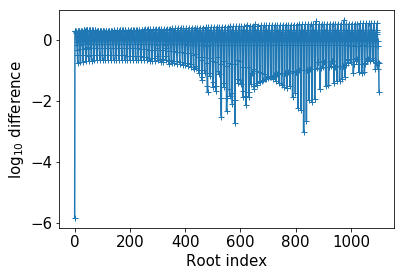

In [7]:
eqns_file = 'results/case3_eqns.txt'
roots_file = 'results/case3_roots.txt'
generateTestBench(num_exp=1100, num_unknwn=1103, eqn_file=eqns_file, iter_mem=[500, 15000, 1], max_mem_size=10000000, 
                  num_pe=1230)
sim(roots_file)

## High level synthesis [HLS] based design synthesis results

### Notes
+ Using the HLS we concluded that the most unit that has a huge performance impact on our design in the Matrix-Vector dot product unit
+ We have explored several design [Design exploration via HLS] by writing the Macro-architecture of several algorithms
+ We ended up using an approach used in the Parallel Processing literature known as **Rowwise block-striped decomposition**
+ This approach requires that every Processing element must have a copy of the vector to be multiplied; but since we have the freedom to descripe our design on the FPGA facbric we avoided such a limitation by modifing our design
+ As suggested in the previous meeting we have utilized the TWO port block ram memory of the FPGA, using this type of memory did impact out performance alot
+ As suggested in the previous meeting we have used broadcasting approach and this had a huge performance impact on our design

### Design features of our latest approach
+ Scalable design that can fit on **Small FPGAs** or **Emulation teconology**
+ Parametrized design. A parameter known as `NUM_PE` can be used to increase the number of processing elements in our design
 + More processing elements means **more area** means **better performance** and **less time** user can do this tradeoff based on the area and resources available
+ Synthesis frequency of `100MHZ`
 
 
### Status
+ Simulation PASS till 1000 unknowns [more can be done]
+ FPGA demo [IN PROGRESS WE ARE MISSING FEW COMPONENTS]
+ Emulator [READY FOR PORTING THOUGH WE NEED TO ASK FEW QUESTIONS]

#### Performance comparison between the two approaches

In [4]:
tbl = pd.read_excel('Book1.xlsx')
tbl

,NUM_PE,Approach 1 LUT consumed,Approach 2 LUT consumed,Notes on performance
0,2,21731,23297,same performance
1,10,83411,36472,same performance
2,20,159428,53068,same performance
3,30,235383,69604,same performance


In [6]:
tbl['Approach 1 LUT consumed'][0]

21731

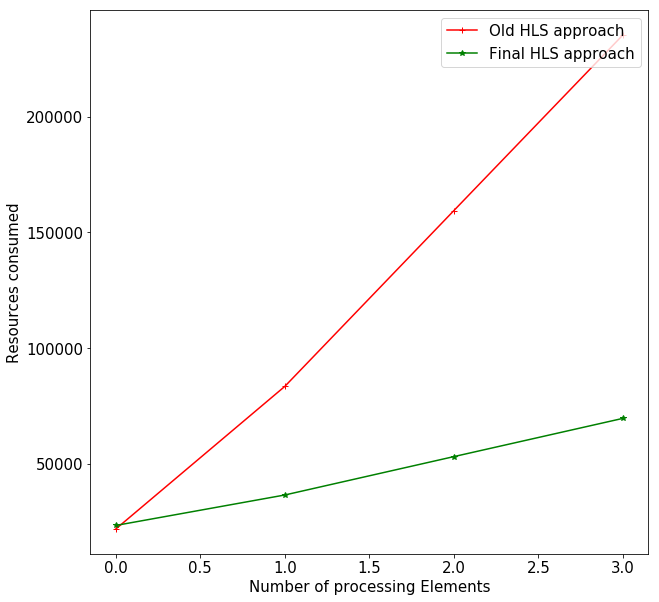

In [21]:
pylab.plot(tbl['Approach 1 LUT consumed'], 'r-+', label="Old HLS approach")
#pylab.legend("Old HLS approach")
pylab.xlabel("Number of processing Elements")
pylab.ylabel("Resources consumed")
pylab.plot(tbl['Approach 2 LUT consumed'], 'g-*', label="Final HLS approach")
pylab.legend(loc='upper right')
pylab.show()

#### LESS AREA and SAME PERFORMANCE

### Resource percentage


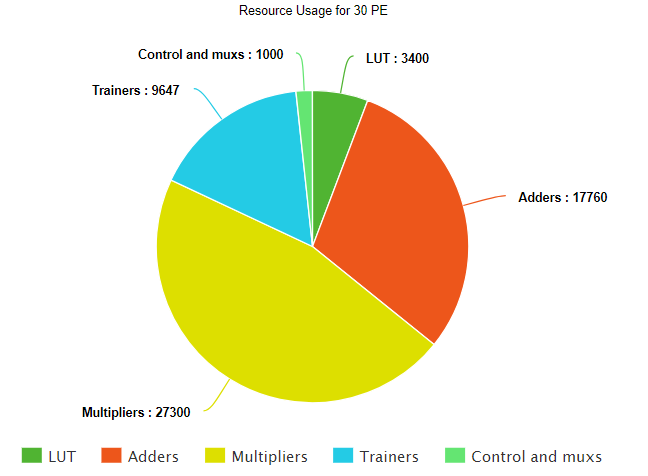